# PING GRAPH

In [83]:
filepath = "rec_2020-09-26_00-46-59.echoreplay"
player_name = "NtsFranz"

In [84]:
# ping graph

import zipfile
import os
import sys
import tempfile
import json
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
format = r'%Y/%m/%d %H:%M:%S.%f'

# ping graph

# extracts the JSON object and the timestamp from a .echoreplay line
def get_frame(line: str):
    timestamp, jsondata = line.split("\t")
    return datetime.datetime.strptime(timestamp, format), json.loads(jsondata)


# finds the player object with the given name or returns None
def get_player(json: str, player_name: str):
    for team in json['teams']:
        if 'players' in team:
            for player in team['players']:
                if player['name'] == player_name:
                    player['game_clock'] = json['game_clock']
                    return player
    return None

# ping graph

# exctract the .echoreplay file
data = []
if zipfile.is_zipfile(filepath):
    # Unzip
    with zipfile.ZipFile(filepath, 'r') as zf:
        with tempfile.TemporaryDirectory() as td:
            zf.extractall(td)
            for entry in os.scandir(td):
                with open(entry.path, 'r') as f:
                    data = f.readlines()
else:
    with open(filepath) as f:
        data = f.readlines()

print("Loaded file into memory ({0} lines)".format(len(data)))
players = [get_player(get_frame(line)[1], player_name) for line in data if len(line) > 800]
df = pd.DataFrame(players)
display(df.head())

Loaded file into memory (19304 lines)


,rhand,playerid,name,userid,stats,number,level,stunned,ping,invulnerable,head,possession,body,lhand,blocking,velocity,game_clock
0,"{'pos': [-0.23500001, -3.3750002, -72.641006],...",0,NtsFranz,1644301615643409,"{'possession_time': 0.0, 'points': 0, 'saves':...",0,50,False,38,False,"{'position': [-0.093000002, -2.9210002, -72.90...",False,"{'position': [-0.093000002, -2.9210002, -72.90...","{'pos': [0.073000006, -3.3380001, -72.688004],...",False,"[0.11300001, -0.44700003, 3.0740001]",300.0
1,"{'pos': [-0.23, -3.3960001, -72.501007], 'forw...",0,NtsFranz,1644301615643409,"{'possession_time': 0.0, 'points': 0, 'saves':...",0,50,False,38,False,"{'position': [-0.088000007, -2.9430001, -72.76...",False,"{'position': [-0.088000007, -2.9430001, -72.76...","{'pos': [0.078000002, -3.3590002, -72.548004],...",False,"[0.11700001, -0.50800002, 3.1930001]",300.0
2,"{'pos': [-0.22700001, -3.4080002, -72.429001],...",0,NtsFranz,1644301615643409,"{'possession_time': 0.0, 'points': 0, 'saves':...",0,50,False,38,False,"{'position': [-0.085000001, -2.9550002, -72.68...",False,"{'position': [-0.085000001, -2.9550002, -72.68...","{'pos': [0.081, -3.3710001, -72.476006], 'forw...",False,"[0.119, -0.53900003, 3.2520001]",300.0
3,"{'pos': [-0.22200002, -3.4340003, -72.281006],...",0,NtsFranz,1644301615643409,"{'possession_time': 0.0, 'points': 0, 'saves':...",0,50,False,38,False,"{'position': [-0.079000004, -2.9810002, -72.54...",False,"{'position': [-0.079000004, -2.9810002, -72.54...","{'pos': [0.086000003, -3.3970001, -72.328003],...",False,"[0.12400001, -0.60000002, 3.3700001]",300.0
4,"{'pos': [-0.21900001, -3.4480002, -72.205002],...",0,NtsFranz,1644301615643409,"{'possession_time': 0.0, 'points': 0, 'saves':...",0,50,False,38,False,"{'position': [-0.077000007, -2.9950001, -72.46...",False,"{'position': [-0.077000007, -2.9950001, -72.46...","{'pos': [0.089000002, -3.4100001, -72.252007],...",False,"[0.126, -0.63100004, 3.4300001]",300.0


In [85]:
import math
def velocityJSONToSpeed(vel):
    vel = vel['velocity']
    return math.sqrt(vel[0]**2 + vel[1]**2 + vel[2]**2)


speedsDF = df[['velocity', 'head','game_clock']]
speedsDF['speed'] = speedsDF.apply(lambda row: velocityJSONToSpeed(row), axis=1)
speedsDF['pos_x'] = speedsDF.apply(lambda row: row['head']['position'][0], axis=1)
speedsDF['pos_y'] = speedsDF.apply(lambda row: row['head']['position'][1], axis=1)
speedsDF['pos_z'] = speedsDF.apply(lambda row: row['head']['position'][2], axis=1)
speedsDF['calculated_zspeed'] = (speedsDF['pos_z'].shift(-1) - speedsDF['pos_z'])/(speedsDF['game_clock'] - speedsDF['game_clock'].shift(-1))
speedsDF['speed_smoothed'] = speedsDF['speed'].rolling(10).mean().shift(-5)
speedsDF['acceleration'] = (speedsDF['speed_smoothed'].shift(-1) - speedsDF['speed_smoothed'])/(speedsDF['game_clock'] - speedsDF['game_clock'].shift(-1))
speedsDF['x'] = speedsDF.index
display(speedsDF.head())
print("Found player in {0} frames.".format(len(df)))

,velocity,head,game_clock,speed,pos_x,pos_y,pos_z,calculated_zspeed,speed_smoothed,acceleration,x
0,"[0.11300001, -0.44700003, 3.0740001]","{'position': [-0.093000002, -2.9210002, -72.90...",300.0,3.108385,-0.093,-2.921,-72.901001,inf,NaN,NaN,0
1,"[0.11700001, -0.50800002, 3.1930001]","{'position': [-0.088000007, -2.9430001, -72.76...",300.0,3.235275,-0.088,-2.943,-72.760002,inf,NaN,NaN,1
2,"[0.119, -0.53900003, 3.2520001]","{'position': [-0.085000001, -2.9550002, -72.68...",300.0,3.298513,-0.085,-2.955,-72.688004,inf,NaN,NaN,2
3,"[0.12400001, -0.60000002, 3.3700001]","{'position': [-0.079000004, -2.9810002, -72.54...",300.0,3.425241,-0.079,-2.981,-72.540001,inf,NaN,NaN,3
4,"[0.126, -0.63100004, 3.4300001]","{'position': [-0.077000007, -2.9950001, -72.46...",300.0,3.489833,-0.077,-2.995,-72.464005,inf,3.486869,inf,4


Found player in 19262 frames.


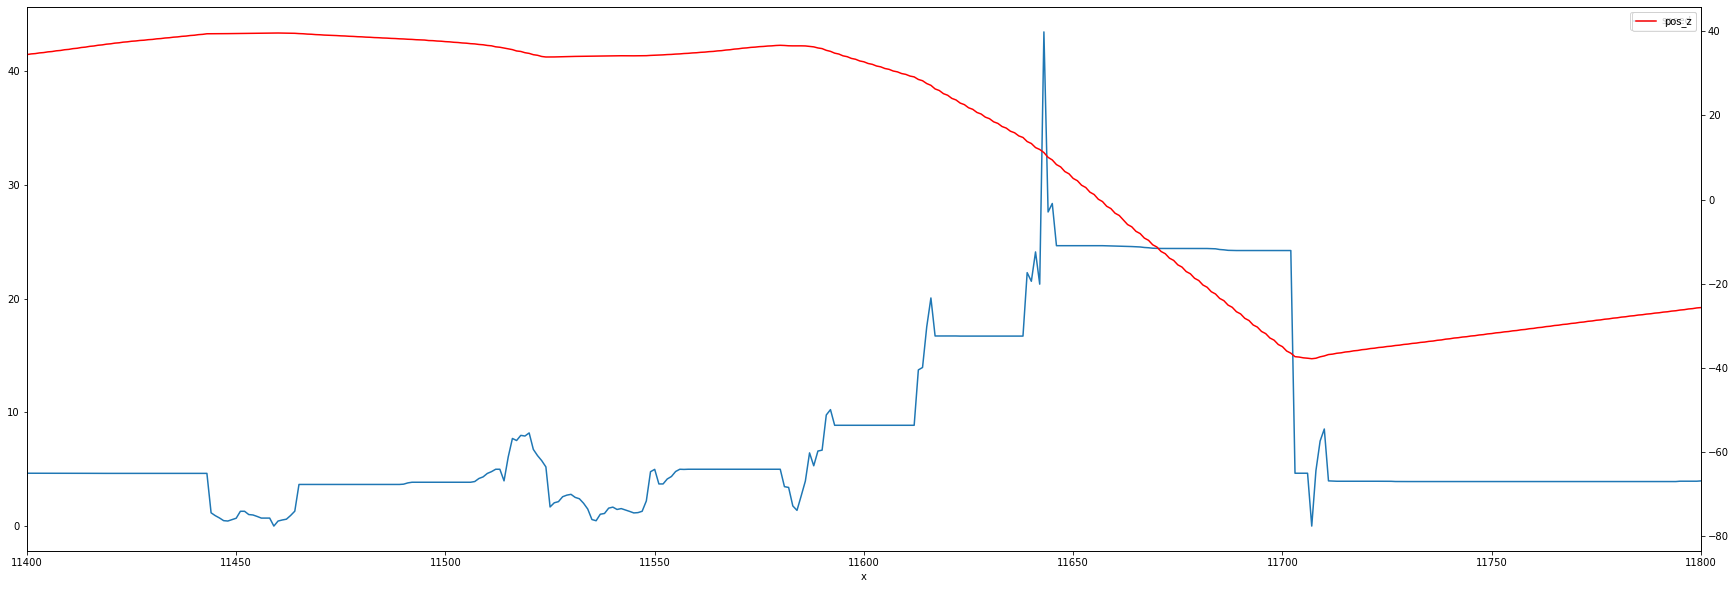

In [97]:
# time series
fig, ax = plt.subplots(figsize=(30,10))

speedsDF.plot(ax=ax, x="x", y="speed")
# speedsDF.plot(ax=ax, x="x", y="game_clock")
# speedsDF.plot(ax=ax, x="x", y="calculated_zspeed")
# speedsDF.plot(ax=ax, x="x", y="acceleration")
# speedsDF.plot(ax=ax, x="x", y="speed_smoothed")

ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis

speedsDF.plot(ax=ax2, x="x", y="pos_z", color="red")
# speedsDF.plot(ax=ax2, x="x", y="pos_x", color="red")
ax.set_xlim(left=11400,right=11800)
# ax.set_ylim(top=25)
# ax.set_xticklabels([])

plt.show()

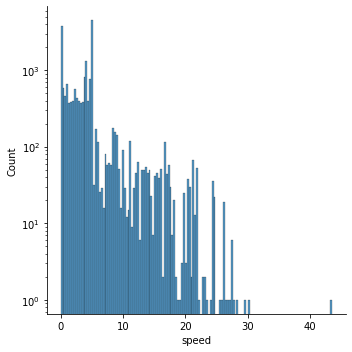

In [87]:
sns.displot(data=speedsDF, x='speed', log=True)